# I am analyzing the number of 311 complaints about street lights between March 2018 and March 2023, using the 311 call records available on NYC OpenData. I am then matching the location of the calls to NYC zipcodes. 

In [1]:
import pandas as pd
import io
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt

## First, I upload the 311 data on complaints about street lights 

In [2]:
df = pd.read_csv('311_street_lights.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('max_seq_item', None)

In [4]:
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract year and create new column
df['year'] = df['Created Date'].dt.year

In [5]:
df['Closed Date'] = pd.to_datetime(df['Closed Date'], errors='coerce')
df['how_long_it_took_to_close'] = df['Closed Date'] - df['Created Date']

In [6]:
df.tail()
df.rename(columns = {'Incident Zip':'zipcode'}, inplace = True)
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,zipcode,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,year,how_long_it_took_to_close
0,57090793,2023-03-21 00:32:00,NaT,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Hanging,NaN,10027.0,3174 BROADWAY,BROADWAY,LA SALLE ST,TIEMANN PL,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Open,NaN,NaN,NaN,09 MANHATTAN,NaN,MANHATTAN,995657.0,236200.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.814983,-73.958790,"(40.81498280473526, -73.95879012453169)",12424.0,37.0,4.0,23.0,17.0,2023,NaT
1,57093090,2023-03-20 23:27:00,NaT,DOT,Department of Transportation,Street Light Condition,Street Light Lamp Dim,NaN,11236.0,NaN,NaN,NaN,NaN,AVENUE J,EAST 86 STREET,INTERSECTION,BROOKLYN,NaN,NaN,Open,NaN,NaN,NaN,18 BROOKLYN,NaN,BROOKLYN,1010050.0,171256.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636697,-73.907042,"(40.63669717144956, -73.907041786675)",13827.0,5.0,2.0,8.0,42.0,2023,NaT
2,57092172,2023-03-20 22:20:00,NaT,DOT,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,11357.0,NaN,NaN,NaN,NaN,25 AVENUE,150 STREET,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1035504.0,221998.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775861,-73.814944,"(40.77586093296771, -73.81494419575927)",13832.0,22.0,3.0,20.0,67.0,2023,NaT
3,57090601,2023-03-20 22:05:00,NaT,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11691.0,20-19 ELK COURT,ELK COURT,BEACH 20 ST,UNNAMED ST,NaN,NaN,ADDRESS,FAR ROCKAWAY,NaN,NaN,Open,NaN,NaN,NaN,14 QUEENS,4.157688e+09,QUEENS,1052354.0,157325.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.598235,-73.754760,"(40.59823537247661, -73.75476021423908)",20529.0,51.0,3.0,47.0,59.0,2023,NaT
4,57097644,2023-03-20 21:14:00,NaT,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11368.0,NaN,NaN,NaN,NaN,34 AVENUE,NORTHERN BLVD EXIT,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1027054.0,216104.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.759728,-73.845491,"(40.75972841557144, -73.84549092094751)",14510.0,67.0,3.0,21.0,68.0,2023,NaT


In [7]:
df= df[['Agency Name', 'Complaint Type', 'Descriptor', 'Location Type', 'zipcode', 'Incident Address','Street Name','City','Created Date', 'Closed Date']]

## Now I upload a csv file containing NYC zipcodes and the borough it is in.

In [8]:
zipcodes_df = pd.read_csv('nyc-zip-codes.csv')
zipcodes_df.rename(columns = {'ZipCode':'zipcode','Borough':'borough','Neighborhood':'neighborhood'}, inplace = True)

## I merge it with the 311 data file 

In [9]:
df = df.merge(zipcodes_df.set_index(['zipcode']), 
                      left_on=['zipcode'], 
                      right_index=True, 
                      how='left')
df.head()

,Agency Name,Complaint Type,Descriptor,Location Type,zipcode,Incident Address,Street Name,City,Created Date,Closed Date,borough,neighborhood
0,Department of Transportation,Street Light Condition,Fixture/Luminaire Hanging,NaN,10027.0,3174 BROADWAY,BROADWAY,NEW YORK,2023-03-21 00:32:00,NaT,Manhattan,Central Harlem
1,Department of Transportation,Street Light Condition,Street Light Lamp Dim,NaN,11236.0,NaN,NaN,BROOKLYN,2023-03-20 23:27:00,NaT,Brooklyn,Canarsie and Flatlands
2,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,11357.0,NaN,NaN,QUEENS,2023-03-20 22:20:00,NaT,Queens,North Queens
3,Department of Transportation,Street Light Condition,Street Light Out,NaN,11691.0,20-19 ELK COURT,ELK COURT,FAR ROCKAWAY,2023-03-20 22:05:00,NaT,Queens,Rockaways
4,Department of Transportation,Street Light Condition,Street Light Out,NaN,11368.0,NaN,NaN,QUEENS,2023-03-20 21:14:00,NaT,Queens,West Queens


## Some information about the general complaints about street lights
### Average time it took to resolve a street light complaint

In [10]:
df['Created Date'] = pd.to_datetime(df['Created Date'])
df['year'] = df['Created Date'].dt.year
df['Closed Date'] = pd.to_datetime(df['Closed Date'], errors='coerce')
df['how_long_it_took_to_close'] = df['Closed Date'] - df['Created Date']
df['how_long_it_took_to_close'].mean()

Timedelta('12 days 13:22:55.899452837')

### How many complaints a year since 2018

In [11]:
df.year.value_counts().sort_index()

2018    58719
2019    68211
2020    65026
2021    56203
2022    57179
2023    11203
Name: year, dtype: int64

### The zipcodes with the most number of complaints

In [12]:
df['zipcode'].value_counts().head()

10465.0    4743
10314.0    4588
10469.0    4302
10461.0    4171
10473.0    3560
Name: zipcode, dtype: int64

### The above information seems to agree with previous reporting that street lights in the Pelham Bay area in the Bronx are being ignored. Four out of five of the zipcodes are in the Bronx. One (10314) is in Staten Island.
https://brooklyn.news12.com/city-island-and-pelham-bay-park-residents-several-streetlights-are-in-urgent-need-of-repairs

### Zooming in to these 5 zip codes

In [13]:
df2= df.loc[[10465.0, 10314.0, 10469.0, 10461.0, 10473.0]]
df2

,Agency Name,Complaint Type,Descriptor,Location Type,zipcode,Incident Address,Street Name,City,Created Date,Closed Date,borough,neighborhood,year,how_long_it_took_to_close
10465,Department of Transportation,Street Light Condition,Fixture/Luminaire Out Of Position,NaN,10025.0,NaN,NaN,MANHATTAN,2023-01-06 14:28:00,2023-01-06 14:28:00,Manhattan,Upper West Side,2023,0 days 00:00:00
10314,Department of Transportation,Street Light Condition,Street Light Out,NaN,10301.0,NaN,NaN,STATEN ISLAND,2023-01-09 09:49:00,2023-01-09 09:49:00,Staten Island,Stapleton and St. George,2023,0 days 00:00:00
10469,Department of Transportation,Street Light Condition,Photocell (PEC) Missing,NaN,10026.0,NaN,NaN,MANHATTAN,2023-01-06 14:23:00,2023-01-06 14:23:00,Manhattan,Central Harlem,2023,0 days 00:00:00
10461,Department of Transportation,Street Light Condition,Photocell (PEC) Missing,NaN,10024.0,NaN,NaN,MANHATTAN,2023-01-06 14:37:00,2023-01-05 14:36:00,Manhattan,Upper West Side,2023,-2 days +23:59:00
10473,Department of Transportation,Street Light Condition,Fixture/Luminaire Door Open,NaN,10028.0,NaN,NaN,MANHATTAN,2023-01-06 14:20:00,2023-01-06 14:20:00,Manhattan,Upper East Side,2023,0 days 00:00:00


In [14]:
df2['how_long_it_took_to_close'].mean()

Timedelta('-1 days +19:11:48')

In [15]:
zip_code_by_year = pd.pivot_table(df, values='Agency Name', index='zipcode', columns='year', aggfunc='count', fill_value=0)

### Number of complaints each year in the top five neighborhoods

In [16]:
top_five_zip_code_by_year = zip_code_by_year.loc[[10465.0, 10314.0, 10469.0, 10461.0, 10473.0]]
top_five_zip_code_by_year['Total'] = top_five_zip_code_by_year.sum(axis=1)
top_five_zip_code_by_year

year,2018,2019,2020,2021,2022,2023,Total
zipcode,,,,,,,
10465.0,585,858,882,894,1313,211,4743
10314.0,1274,792,796,766,812,148,4588
10469.0,611,828,859,856,1062,86,4302
10461.0,459,748,838,805,1151,170,4171
10473.0,528,740,728,724,777,63,3560


## Correlation analysis:
### My first null hypothesis is that there is no significant association between the nubmer of street light complaints and the number of people living in a zipcode. — I did this analysis below 
### My second null hypothesis is that there is no significant association between the nubmer of street light complaints and the number of vehicle crashes at night in a zipcode. — I will do this analysis for the multivariate regression this week 


In [17]:
import glob
import json
import requests
from pprint import pprint

In [18]:
from us import states # US state abbreviations, and a few other things

# datamade's Census package
from census import Census
c = Census("")

In [19]:
TABLE = 'B01003' #population

# Here I use data from the 5-year American Community Survey
# In this python package that is "c.acs5"
# Check DataMade's documentation for other options like acs1, pf, sf1, etc...
# https://pypi.org/project/census/
for t in c.acs5.tables():
    if TABLE in t['name']:
        pprint(t)
        print("\n")

        variables_url = t['variables']
        response = requests.get(variables_url).json()
        print(f"Variables for table {t['name']}, {t['description']}:")
        variables = pd.DataFrame(response['variables'])
        display(variables)

{'description': 'TOTAL POPULATION',
 'name': 'B01003',
 'universe ': 'TOTAL_POP',
 'variables': 'http://api.census.gov/data/2020/acs/acs5/groups/B01003.json'}


Variables for table B01003, TOTAL POPULATION:


,B01003_001E,B01003_001M,B01003_001MA,B01003_001EA
label,Estimate!!Total,Margin of Error!!Total,Annotation of Margin of Error!!Total,Annotation of Estimate!!Total
concept,TOTAL POPULATION,TOTAL POPULATION,TOTAL POPULATION,TOTAL POPULATION
predicateType,int,int,string,string
group,B01003,B01003,B01003,B01003
limit,0,0,0,0
predicateOnly,True,True,True,True
universe,TOTAL_POP,TOTAL_POP,TOTAL_POP,TOTAL_POP


In [20]:
year = 2019
state = states.NY
population = pd.DataFrame(
    c.acs5.state_zipcode(
        fields = ['NAME'] + list(variables.columns),
        state_fips = state.fips, 
        year = year,
        zcta='*',
        table=[TABLE]))\
    .rename(columns={'zip code tabulation area':'zip'})

population['state'] = population.state.apply(lambda x: states.lookup(x).name)
population = population[['zip', 'state', 'NAME'] + list(variables.columns)]
population.rename(columns = {'zip':'zipcode'}, inplace = True)
labels = dict(variables.loc['label'])
population.rename(columns=labels)
population['zipcode'] = population['zipcode'].astype(float)
df = df.merge(population.set_index(['zipcode']), 
                      left_on=['zipcode'], 
                      right_index=True, 
                      how='left')

In [21]:
df.to_csv('population_and_street_lights.csv', index=False)

In [22]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [23]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [24]:
%%R

require('tidyverse')
require('ggrepel')
library(ggrepel)

R[write to console]: Loading required package: tidyverse



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: ggrepel



In [25]:
%%R

# Read data
df <- read_csv('population_and_street_lights.csv')
df

Rows: 316541 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): Agency Name, Complaint Type, Descriptor, Incident Address, Street...
dbl   (4): zipcode, year, B01003_001E, B01003_001M
lgl   (3): Location Type, B01003_001MA, B01003_001EA
dttm  (2): Created Date, Closed Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 316,541 × 20
   `Agency Name`           Compl…¹ Descr…² Locat…³ zipcode Incid…⁴ Stree…⁵ City 
   <chr>                   <chr>   <chr>   <lgl>     <dbl> <chr>   <chr>   <chr>
 1 Department of Transpor… Street… Fixtur… NA        10027 3174 B… BROADW… NEW …
 2 Department of Transpor… Street… Street… NA        11236 <NA>    <NA>    BROO…
 3 Department of Transpor… Street… Street… NA        11357 <NA>    <NA>    QUEE…
 4 Department of Transpor… Street… Street… NA        11691 20-19 … ELK CO

### Creating a new df with just the zipcode and the number of street light complaints in each zipcode

In [66]:
zip_counts = df['zipcode'].value_counts()

# create a new dataframe with the zipcode counts
zip_df = pd.DataFrame({'zipcode': zip_counts.index, 'complaint_count': zip_counts.values})
zip_df.head()

,zipcode,complaint_count
0,10465.0,4743
1,10314.0,4588
2,10469.0,4302
3,10461.0,4171
4,10473.0,3560


### Merging it with population per zipcode data

In [67]:
zip_df = zip_df.merge(population.set_index(['zipcode']), 
                      left_on=['zipcode'], 
                      right_index=True, 
                      how='left')
zip_df.head()

,zipcode,complaint_count,state,NAME,B01003_001E,B01003_001M,B01003_001MA,B01003_001EA
0,10465.0,4743,New York,ZCTA5 10465,43671.0,1255.0,None,None
1,10314.0,4588,New York,ZCTA5 10314,89792.0,1843.0,None,None
2,10469.0,4302,New York,ZCTA5 10469,72384.0,2116.0,None,None
3,10461.0,4171,New York,ZCTA5 10461,49690.0,1542.0,None,None
4,10473.0,3560,New York,ZCTA5 10473,59579.0,2065.0,None,None


### highlighting the zipcodes with the top five street light complaints 

`geom_smooth()` using formula = 'y ~ x'


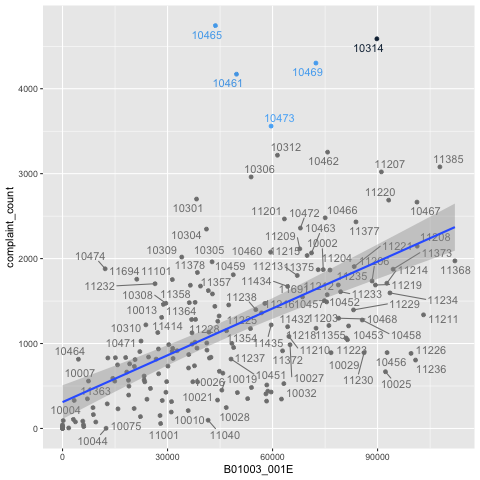

In [68]:
%%R -i zip_df

highlight_zips <- c(10465.0, 10314.0, 10469.0, 10461.0, 10473.0)

ggplot(zip_df) +
    aes(x=B01003_001E, y=complaint_count, label=zipcode, color=ifelse(zipcode %in% highlight_zips, zipcode, NA)) +
    scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
    geom_text_repel() +
    geom_point() +
    geom_smooth(method='lm') +
    guides(color=FALSE)

In [69]:
%%R -i zip_df

streetlights_population <- lm(complaint_count ~ B01003_001E, data=zip_df)
summary(streetlights_population)


Call:
lm(formula = complaint_count ~ B01003_001E, data = zip_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1358.9  -409.1  -129.5   264.7  3630.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.101e+02  1.008e+02   3.076  0.00241 ** 
B01003_001E 1.838e-02  1.921e-03   9.571  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 743.1 on 189 degrees of freedom
  (10 observations deleted due to missingness)
Multiple R-squared:  0.3264,	Adjusted R-squared:  0.3229 
F-statistic: 91.59 on 1 and 189 DF,  p-value: < 2.2e-16



### According to the analysis, there seems to be a significant relationship between the neighborhood's/zipcode's population and the number of street light complaints. However, only about one-third of the complaints can be explained by the neighborhood's population — it doesn't seem like a lot. Lastly, for every increase in 1 person in population, the number of complaints go up by 0.01838. This means for every 1000 more people in each zip code, there are about 18 more complaints.

* As much as there is a significant relationship, it doesn't seem very newsworthy to talk about population
and increase in complaints, I feel. I think seeing if there's a relationship between accidents and complaints
will be more interesting.

## Now going to traffic accidents. 

In [30]:
traffic_df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv')
traffic_df

In [31]:
traffic_df= traffic_df[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE','LOCATION','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED']]

# convert 'CRASH TIME' column to datetime dtype
traffic_df['CRASH TIME'] = pd.to_datetime(traffic_df['CRASH TIME'])

# filter for rows where hour is between 17:00 and 07:00
mask = (traffic_df['CRASH TIME'].dt.hour >= 17) | (traffic_df['CRASH TIME'].dt.hour < 7)
filtered_traffic_df = traffic_df[mask]

#renaming zipcode column
filtered_traffic_df.rename(columns = {'ZIP CODE':'zipcode'}, inplace = True)

# display the resulting DataFrame
filtered_traffic_df.tail()
df1=filtered_traffic_df

### The # below was me extracting the NaN zipcode rows for crashes between 17:00 and 7:00 and then geocoding them

In [80]:
# getting rows where there is no zipcode data but there is lat and long data. pulling these out for anlaysis on geocode.io
#mask = filtered_traffic_df['zipcode'].isnull() & filtered_traffic_df['LATITUDE'].notnull() & filtered_traffic_df['LONGITUDE'].notnull()

# use the mask to select the relevant rows
#nan_rows = filtered_traffic_df[mask]

# display the resulting DataFrame
#nan_rows.to_csv('nan_zipcode.csv', index=False)
#len(nan_rows)
#nan_rows = traffic_crashes_with_zipcodes

In [33]:
df2 = pd.read_csv('traffic_crashes_with_zipcodes.csv')

## I join the 2 tables together — the one with the pre-existing zipcode data, and the ones where I had to geocode

In [34]:
all_crashes_with_zipcodes = pd.concat([df1, df2], axis=0)

In [36]:
all_crashes_with_zipcodes['CRASH DATE'] = pd.to_datetime(all_crashes_with_zipcodes['CRASH DATE'])

# Extract year and create new column
all_crashes_with_zipcodes['year'] = all_crashes_with_zipcodes['CRASH DATE'].dt.year

In [37]:
all_crashes_with_zipcodes.head()

,CRASH DATE,CRASH TIME,BOROUGH,zipcode,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,year,Latitude,Longitude,Accuracy Score,Accuracy Type,Number,Street,City,State,County,Country,Source,CRASH DATE.1
0,2018-03-20,2023-04-13 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-20,2023-04-13 19:00:00,MANHATTAN,10019.0,NaN,NaN,NaN,0.0,0.0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-20,2023-04-13 21:27:00,BRONX,10467.0,NaN,NaN,NaN,0.0,0.0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-03-20,2023-04-13 01:10:00,NaN,NaN,40.664993,-73.802290,"(40.664993, -73.80229)",0.0,0.0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2018-03-20,2023-04-13 20:00:00,BROOKLYN,11229.0,40.610947,-73.953606,"(40.610947, -73.953606)",0.0,0.0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
len(all_crashes_with_zipcodes)

445002

In [70]:
all_crashes_just_zipcodes = all_crashes_with_zipcodes.zipcode.value_counts().to_frame().reset_index()
all_crashes_just_zipcodes.columns = ['zipcode', 'crash_count']
all_crashes_just_zipcodes.head()

,zipcode,crash_count
0,11207.0,6987
1,11236.0,4689
2,11208.0,4614
3,11368.0,4292
4,11434.0,4188


In [71]:
complaints_v_crashes = zip_df.merge(all_crashes_just_zipcodes.set_index(['zipcode']), 
                      left_on=['zipcode'], 
                      right_index=True, 
                      how='left')
complaints_v_crashes.head()

,zipcode,complaint_count,state,NAME,B01003_001E,B01003_001M,B01003_001MA,B01003_001EA,crash_count
0,10465.0,4743,New York,ZCTA5 10465,43671.0,1255.0,None,None,1626.0
1,10314.0,4588,New York,ZCTA5 10314,89792.0,1843.0,None,None,2908.0
2,10469.0,4302,New York,ZCTA5 10469,72384.0,2116.0,None,None,2332.0
3,10461.0,4171,New York,ZCTA5 10461,49690.0,1542.0,None,None,2089.0
4,10473.0,3560,New York,ZCTA5 10473,59579.0,2065.0,None,None,1507.0


`geom_smooth()` using formula = 'y ~ x'


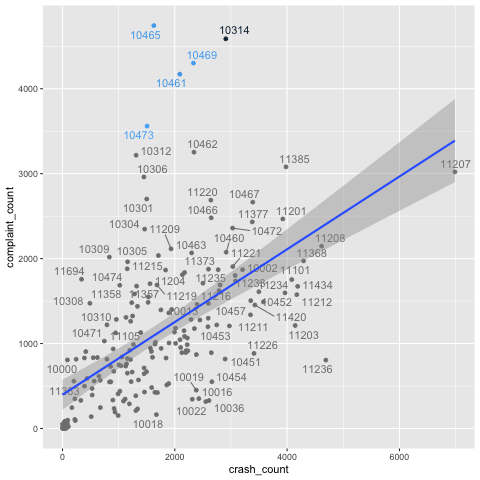

In [72]:
%%R -i complaints_v_crashes

highlight_zips <- c(10465.0, 10314.0, 10469.0, 10461.0, 10473.0)

ggplot(complaints_v_crashes) +
    aes(x=crash_count, y=complaint_count, label=zipcode, color=ifelse(zipcode %in% highlight_zips, zipcode, NA)) +
    scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
    geom_text_repel() +
    geom_point() +
    geom_smooth(method='lm') +
    guides(color=FALSE)

In [77]:
%%R -i complaints_v_crashes

multiv_analysis <- lm("complaint_count ~ crash_count", data=complaints_v_crashes)
summary(multiv_analysis)


Call:
lm(formula = "complaint_count ~ crash_count", data = complaints_v_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-1599.9  -405.6  -207.1   275.8  3650.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 396.58913   90.19088   4.397 1.79e-05 ***
crash_count   0.42830    0.04509   9.500  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 752.7 on 197 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.3142,	Adjusted R-squared:  0.3107 
F-statistic: 90.24 on 1 and 197 DF,  p-value: < 2.2e-16



In [73]:
%%R -i complaints_v_crashes

multiv_analysis <- lm("complaint_count ~ crash_count + B01003_001E", data=complaints_v_crashes)
summary(multiv_analysis)


Call:
lm(formula = "complaint_count ~ crash_count + B01003_001E", data = complaints_v_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-1563.8  -385.4  -158.8   271.0  3634.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.729e+02  1.008e+02   2.708   0.0074 ** 
crash_count 1.771e-01  7.419e-02   2.387   0.0180 *  
B01003_001E 1.255e-02  3.094e-03   4.056 7.31e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 734 on 188 degrees of freedom
  (10 observations deleted due to missingness)
Multiple R-squared:  0.3462,	Adjusted R-squared:  0.3393 
F-statistic: 49.78 on 2 and 188 DF,  p-value: < 2.2e-16



In [74]:
%%R -i complaints_v_crashes

multiv_analysis <- lm("complaint_count ~ I(crash_count**2)", data=complaints_v_crashes)
summary(multiv_analysis)


Call:
lm(formula = "complaint_count ~ I(crash_count**2)", data = complaints_v_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-1608.7  -553.2  -151.6   318.2  3755.8 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.922e+02  7.129e+01  11.112  < 2e-16 ***
I(crash_count^2) 7.375e-05  1.049e-05   7.028 3.34e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 812.7 on 197 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2005,	Adjusted R-squared:  0.1964 
F-statistic:  49.4 on 1 and 197 DF,  p-value: 3.337e-11



In [75]:
%%R -i complaints_v_crashes

multiv_analysis <- lm("complaint_count ~ I(log(crash_count))", data=complaints_v_crashes)
summary(multiv_analysis)


Call:
lm(formula = "complaint_count ~ I(log(crash_count))", data = complaints_v_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-1122.9  -453.8  -160.0   278.8  3465.7 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1001.75     233.79  -4.285 2.86e-05 ***
I(log(crash_count))   308.24      33.57   9.183  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 760.6 on 197 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2998,	Adjusted R-squared:  0.2962 
F-statistic: 84.33 on 1 and 197 DF,  p-value: < 2.2e-16



In [76]:
%%R -i complaints_v_crashes

multiv_analysis <- lm("complaint_count ~ crash_count:B01003_001E", data=complaints_v_crashes)
summary(multiv_analysis)


Call:
lm(formula = "complaint_count ~ crash_count:B01003_001E", data = complaints_v_crashes)

Residuals:
    Min      1Q  Median      3Q     Max 
-1909.7  -585.7  -151.5   272.3  3740.5 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.999e+02  7.582e+01   9.231  < 2e-16 ***
crash_count:B01003_001E 4.261e-06  5.107e-07   8.343 1.49e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 774 on 189 degrees of freedom
  (10 observations deleted due to missingness)
Multiple R-squared:  0.2691,	Adjusted R-squared:  0.2653 
F-statistic:  69.6 on 1 and 189 DF,  p-value: 1.495e-14



## Correlation analysis answer:
### My second null hypothesis was that there is no significant association between the number of street light complaints and the number of vehicle crashes at night in a zipcode. 
#### According to the analysis, similar to the population anlysis, there seems to be a significant relationship between the neighborhood's/zipcode's vehicle crashes at night and the number of street light complaints. For every increase in 100 people in complaints, the number of vehicle crashes go up by 42. This does seem like a huge number. However, only about one-third of the complaints can be explained by the neighborhood's crashes, which does not seem enough to say that there is a correlation, but I will check with the stats person. 
#### When I add crashes and population together, it seems like adding the count of crashes isn't significantly better than just using population alone. Also, the adjusted R^2 is again about a third. This feels surprising to me because I assumed crashes and complaints have a more significant relationship than population and complaints. 
#### While the interaction between crash counts and population is significant, the adjusted R^2 is only around 0.27, which means only about a quarter of the variance in complaints can be explained by vehicle crashes and population affecting each other.